![image-caption](timesries_anomaly_detection.jpg)

<h1>Unsupervised Multivariate Timeseries Outlier Detection</h1>

This example generates sample timeseries data with outliers and shows a simple method of detecting those outliers.<br>
A method is provided for generating various timeseries with both single variable outliers and also with multi-variable outliers that occur at the same time.<br>
Plots of the timeseries, thresholds, and the outliers are shown.<br><br>
At the end a simple example is provided using the KModes class to cluster the binary fields in the dataset that indicate which rows are outliers.<br>
These clusters (once categorized by domain experts) can be used for quick root cause predicts.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

<h3>Generate a pandas DataFrame timeseries to add feature columns to</h3>

In [2]:
# Generate timeseries
from pandas.tseries.offsets import DateOffset
df = pd.DataFrame()
ts = pd.Timestamp('2017-03-06 00:00:00')
df['idx'] = np.arange(0,12 * 24 * 7)
df['date'] = df['idx'].apply(lambda x: ts + DateOffset(minutes=x*5))
df.drop(columns=['idx'], inplace=True)
_ = df.set_index('date', inplace=True, drop=True)
df.head()

""
date
2017-03-06 00:00:00
2017-03-06 00:05:00
2017-03-06 00:10:00
2017-03-06 00:15:00
2017-03-06 00:20:00


<h3>Generate a feature column using a distribution within a range of values</h3>

In [3]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(1, 15000))
X = scaler.fit_transform(np.random.exponential(1,df.shape[0]).reshape(-1, 1))

<h3>Visualize values generated</h3>

In [4]:
# View hist of feature
count, division = np.histogram(X)
data_dict = {'count':count,'division':division}
df_hist = pd.DataFrame({ key:pd.Series(value) for key, value in data_dict.items() }).fillna(0)
df_hist

,count,division
0,1298.0,1.0
1,445.0,1500.9
2,181.0,3000.8
3,49.0,4500.7
4,26.0,6000.6
5,11.0,7500.5
6,1.0,9000.4
7,3.0,10500.3
8,1.0,12000.2
9,1.0,13500.1


array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

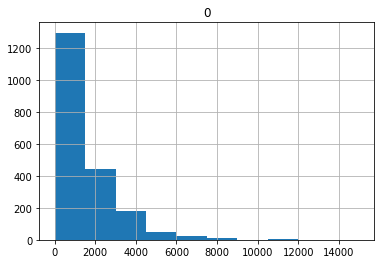

In [5]:
pd.DataFrame(X).hist()

<AxesSubplot:>

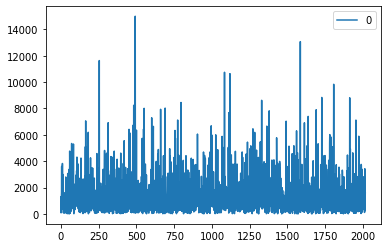

In [6]:
pd.DataFrame(X).plot()

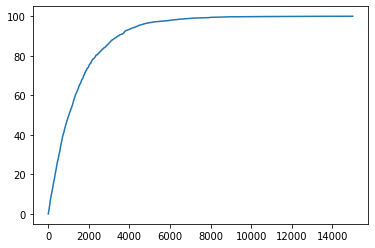

In [7]:
from statsmodels.distributions.empirical_distribution import ECDF
ecdf = ECDF(X.ravel())
plt.plot(ecdf.x, ecdf.y * 100)

<h3>Define a function to generate timeseries dataset and optional anomalous events (single-feature / multivariate)</h3>

In [8]:
def GenerateMultivariateTimeseries(params):
    """
    Passed distribution types must accept an arg called size which will be the count of the timeseries dataframe rows.
    """
    from pandas.tseries.offsets import DateOffset
    from sklearn.preprocessing import MinMaxScaler
    # Generate timeseries    
    df = pd.DataFrame()
    ts = pd.Timestamp(params['starting_date'])
    df['idx'] = np.arange(0,params['timebin_count'])
    df['date'] = df['idx'].apply(lambda x: ts + DateOffset(**{params['timebin_type']:x*params['timebin_length']}))
    df.drop(columns=['idx'], inplace=True)
    df.set_index('date', inplace=True, drop=True)
    # Generate features
    for feature_name in params['feature_names']:
        feature_range = params['feature_profiles'][feature_name]['value_minmax_range']
        distribution = params['feature_profiles'][feature_name]['distribution_type']
        distribution_params = params['feature_profiles'][feature_name]['distribution_params']
        distribution_params['size'] = df.shape[0]
        scaler = MinMaxScaler(feature_range=feature_range)
        df[feature_name] = scaler.fit_transform(distribution(**distribution_params).reshape(-1, 1))
    existing_anomalous_subseries = []
    
    # Insert single-feature or multivariate anomalies that last more than one timebin
    for feature_subseries in params['anomalous_feature_subseries']:
        add_labels = feature_subseries['add_labels']
        if add_labels and 'label' not in df.columns:
            df['label'] = 0
        
        # Find a range within the timeseries to insert the anomalous values that is not already being used
        subseries = None
        for anomaly_idx in range(feature_subseries['anomalous_event_count']):
            # Randomly select a location in the timeseries to insert an anomalous subseries
            subseries_length = feature_subseries['anomalous_event_timebin_count']
            # Maximum of 20 tries to find an anomaly free subseries
            subseries_found = False
            for attempt in range(20):
                starting_position = np.random.randint(df.shape[0]-subseries_length)
                subseries = (starting_position, starting_position+subseries_length)
                # Remember anomalous subseries created so we can make sure not to create any that overlap
                if subseries not in existing_anomalous_subseries:
                    existing_anomalous_subseries.append(subseries)
                    subseries_found = True
                    break
            if subseries_found == False:
                break
            
            # Subseries found so continue
        
            # Replace feature values with anomalous values (more than one feature involved creates an interaction anomaly)
            for feature_name in feature_subseries['features_involved']:
                anomalous_value_range = feature_subseries['feature_profiles'][feature_name]['anomalous_value_range']
                trending_up = feature_subseries['feature_profiles'][feature_name]['trending_up']
                trending_down = feature_subseries['feature_profiles'][feature_name]['trending_up']

                previous_anomalous_value = None
                for idx in range(subseries[0], subseries[1]):
                    if anomalous_value_range[1] > 1:
                        # Integer value range
                        anomalous_value = np.random.randint(anomalous_value_range[0], anomalous_value_range[1])
                        # Handle trending up or down if enabled
                        if previous_anomalous_value != None and trending_up:
                            if anomalous_value < previous_anomalous_value:
                                anomalous_value = previous_anomalous_value + 1
                            else:
                                previous_anomalous_value = anomalous_value
                        else:
                            previous_anomalous_value = anomalous_value
                        if previous_anomalous_value != None and trending_down:
                            if anomalous_value > previous_anomalous_value:
                                anomalous_value = previous_anomalous_value - 1
                            else:
                                previous_anomalous_value = anomalous_value
                        else:
                            previous_anomalous_value = anomalous_value
                        
                        # Overwrite random value with new anomalous value
                        df.loc[df.index[idx], feature_name] = anomalous_value
                        if add_labels:
                            df.loc[df.index[idx], 'label'] = 1
    return df

<h3>Configure a timeseries dataset to generate</h3>

In [9]:
params = {
    'timebin_type': 'minutes',
    'timebin_length': 5,
    'starting_date': '2022-01-01 00:00:00',
    'timebin_count': 12 * 24 * 30,
    'feature_names':['f1','f2','f3'],
    'feature_profiles': {
        'f1':{
            'distribution_type': np.random.exponential,
            'distribution_params': {'scale':1 },
            'value_minmax_range': (0,15000)
        },
        'f2':{
            'distribution_type': np.random.exponential,
            'distribution_params': {'scale':1 },
            'value_minmax_range': (0,15000)
        },
        'f3':{
            'distribution_type': np.random.normal,
            'distribution_params': {'loc':500, 'scale':1 },
            'value_minmax_range': (100,800)
        }
    },
    'anomalous_feature_subseries': [
        {
        'features_involved': ['f1'],
        'anomalous_event_count': 2,
        'anomalous_event_timebin_count': 130,
        'add_labels': False,
        'feature_profiles': {
            'f1': {
                'anomalous_value_range': (20000,25000),
                'trending_up': False,
                'trending_down': False
            }
        }
    },
        {
        'features_involved': ['f2', 'f3'],
        'anomalous_event_count': 1,
        'anomalous_event_timebin_count': 30,
        'add_labels': False,
        'feature_profiles': {
            'f2': {
                'anomalous_value_range': (15000,20000),
                'trending_up': False,
                'trending_down': False
            },
            'f3': {
                'anomalous_value_range': (0,25),
                'trending_up': False,
                'trending_down': False
            }
        }
    }]
}



timeseriesDF = GenerateMultivariateTimeseries(params)

<h3>Find out what is the normal (median) min / max values daily for each feature </h3>

In [ ]:
df = timeseriesDF
df.loc[:, 'byDay'] = df.index.month.astype('str') + '~' + df.index.day.astype('str')
daily_grouping = df.groupby('byDay')

# Calculate the max timebin per day across the timeseries and then take the median
daily_norm = {}
daily_norm['f1'] = {'min':daily_grouping['f1'].min().quantile([0.5]).iloc[0], 'max':daily_grouping['f1'].max().quantile([0.5]).iloc[0]}
daily_norm['f2'] = {'min':daily_grouping['f2'].min().quantile([0.5]).iloc[0], 'max':daily_grouping['f2'].max().quantile([0.5]).iloc[0]}
daily_norm['f3'] = {'min':daily_grouping['f3'].min().quantile([0.5]).iloc[0], 'max':daily_grouping['f3'].max().quantile([0.5]).iloc[0]}
print(daily_norm)

{'f1': {'min': 4.816512670423064, 'max': 10648.43603494567}, 'f2': {'min': 3.5382257588538746, 'max': 9335.7324009894}, 'f3': {'min': 176.7646560544963, 'max': 709.5075670277656}}


<h3>Add new columns for each feature that is a measure of the original value relative to the normal daily min / max</h3>

In [214]:
# Create normalized version of each feature
df['f1_norm_max'] = df['f1'] / max(daily_norm['f1']['max'], 1)
df['f2_norm_max'] = df['f2'] / max(daily_norm['f2']['max'], 1)
df['f3_norm_max'] = df['f3'] / max(daily_norm['f3']['max'], 1)
df['f3_norm_min'] = df['f3'] / max(daily_norm['f3']['min'], 1)
print(daily_norm)
print('')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
df.describe()

{'f1': {'min': 4.816512670423064, 'max': 10648.43603494567}, 'f2': {'min': 3.5382257588538746, 'max': 9335.7324009894}, 'f3': {'min': 176.7646560544963, 'max': 709.5075670277656}}



,f1,f2,f3,f1_norm_max,f2_norm_max,f3_norm_max,f3_norm_min
count,8640.000000,8640.000000,8640.000000,8640.000000,8640.000000,8640.000000,8640.000000
mean,2430.673796,1555.471284,441.064071,0.228266,0.166615,0.621648,2.495205
std,3970.047100,1802.089808,96.258843,0.372829,0.193031,0.135670,0.544559
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,542.172631,416.559781,379.452063,0.050916,0.044620,0.534810,2.146651
50%,1300.585959,1024.340556,442.365453,0.122139,0.109723,0.623482,2.502567
75%,2702.922490,2090.375453,504.484362,0.253833,0.223911,0.711035,2.853989
max,24992.000000,19944.000000,800.000000,2.347011,2.136308,1.127543,4.525792


In [ ]:
df.sample(10)

<h3>Visualize the dataset generated</h3>

Text(2022-01-14 06:20:00, 10648.43603494567, 'daily median max')

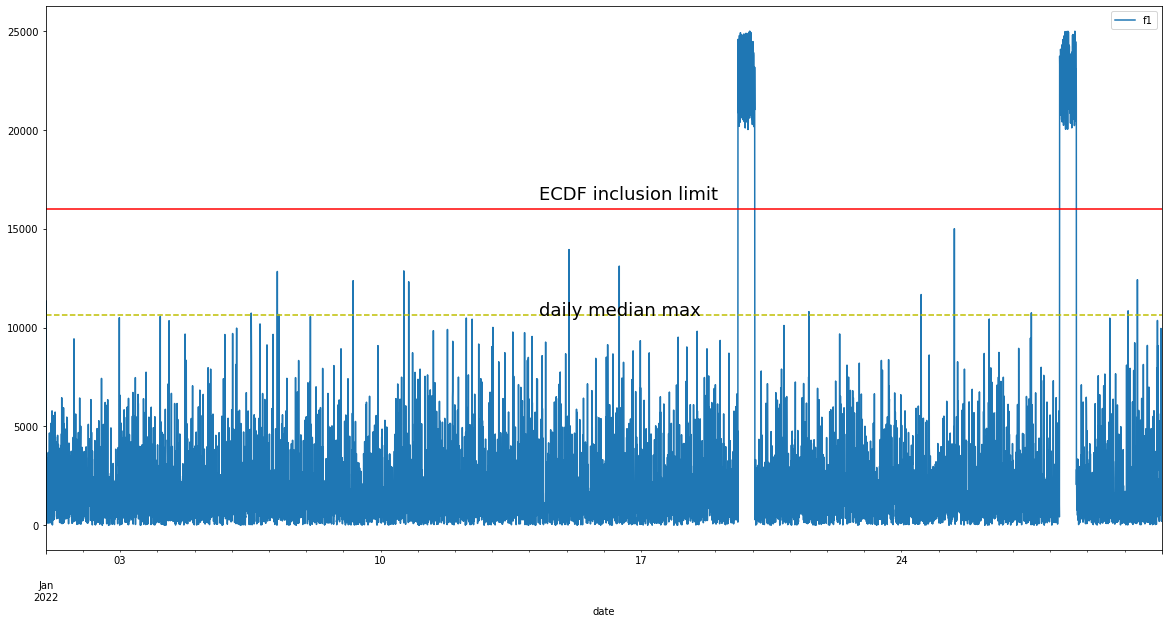

In [12]:
fig, ax = plt.subplots()
timeseriesDF.plot(y='f1', figsize=(20, 10), ax=ax)
# Values less than or equal to the horizontal line will be included in the daily normal max ECDF table to decide rarity
ECDF_inclusion_limit = daily_norm['f1']['max'] * 1.5
plt.axhline(y=ECDF_inclusion_limit, color='r', linestyle='-')
ax.text(timeseriesDF.index[(timeseriesDF.shape[0]//2)-500], ECDF_inclusion_limit+500, 'ECDF inclusion limit', size=18, fontdict=None)

plt.axhline(y=daily_norm['f1']['max'], color='y', linestyle='--')
ax.text(timeseriesDF.index[(timeseriesDF.shape[0]//2)-500], daily_norm['f1']['max'], 'daily median max', size=18, fontdict=None)

<h2>Outlier detection for each single feature signal</h2>

<h3>Create ECDF tables from the history that can be used to tell us how rare all new timebins are compared to historical norms</h3>

<b>Some features you only care about max value outliers, some only min value outliers, and some both.</b>

<b>The higher percentile any new timebins map to the more rare that new timebin is. A 100% means history only has seen values that extreme rarely (e.g. once or twice) or never.</b>

<h3>ECDF for feature signal 'f1' daily max norms</h3>

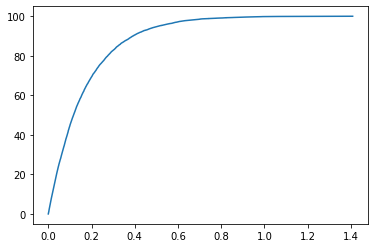

In [13]:
from statsmodels.distributions.empirical_distribution import ECDF
# Only include values from history that are up to 1.5 times the historical norms incase the history contains outliers
ecdf = ECDF(df[df['f1'] <= daily_norm['f1']['max'] * 1.5]['f1_norm_max'])
plt.plot(ecdf.x, ecdf.y * 100)

<h3>ECDF for feature signal 'f2' daily max norms</h3>

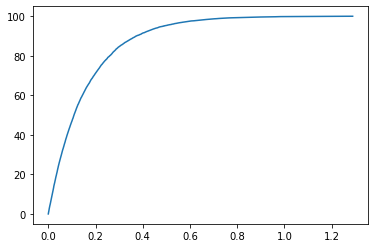

In [14]:
from statsmodels.distributions.empirical_distribution import ECDF
# Values less than or equal to the horizontal line will be included in the daily normal max ECDF table to decide rarity
ECDF_inclusion_limit = daily_norm['f2']['max'] * 1.5
# Only include values from history that are up to 1.5 times the historical norms incase the history contains outliers
ecdf = ECDF(df[df['f2'] <= ECDF_inclusion_limit]['f2_norm_max'])
plt.plot(ecdf.x, ecdf.y * 100)

Text(2022-01-14 06:20:00, 9335.7324009894, 'daily median max')

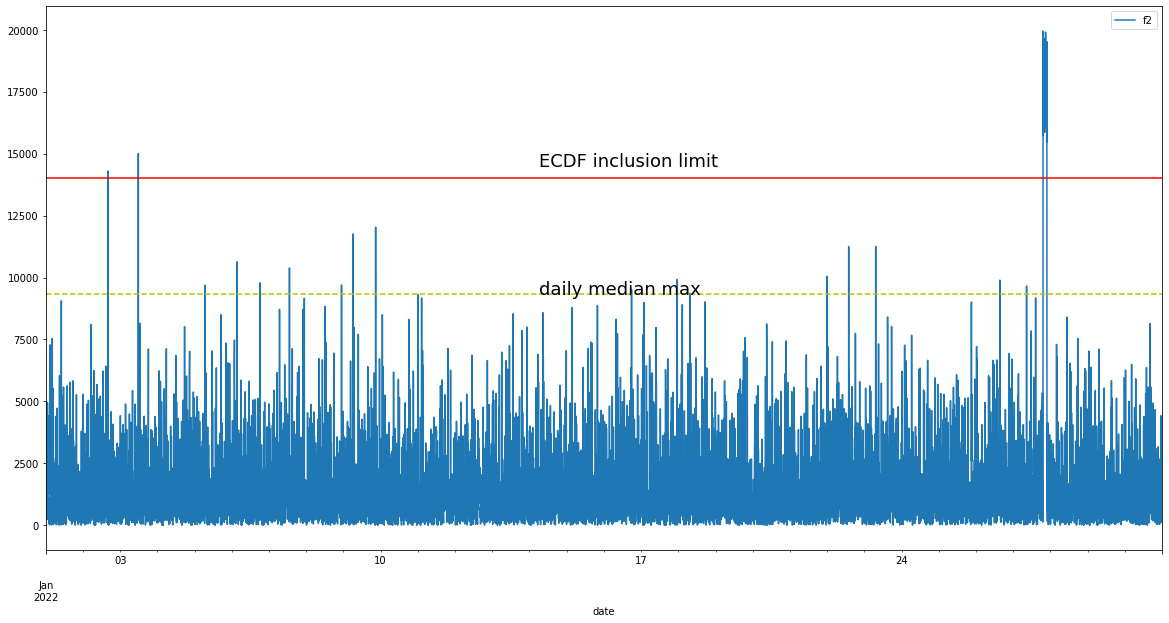

In [15]:
fig, ax = plt.subplots()
timeseriesDF.plot(y='f2', figsize=(20, 10), ax=ax)
plt.axhline(y=ECDF_inclusion_limit, color='r', linestyle='-')
ax.text(timeseriesDF.index[(timeseriesDF.shape[0]//2)-500], ECDF_inclusion_limit+500, 'ECDF inclusion limit', size=18, fontdict=None)

plt.axhline(y=daily_norm['f2']['max'], color='y', linestyle='--')
ax.text(timeseriesDF.index[(timeseriesDF.shape[0]//2)-500], daily_norm['f2']['max'], 'daily median max', size=18, fontdict=None)

Text(0.5, 1.0, 'f3 daily norm max')

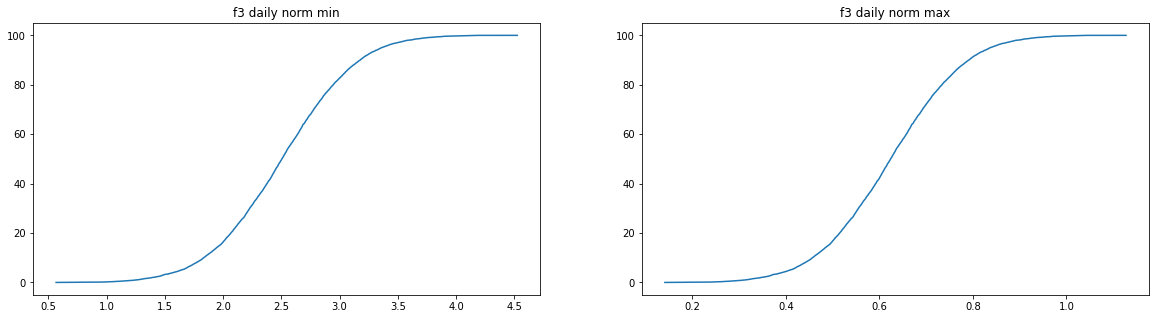

In [26]:
# from statsmodels.distributions.empirical_distribution import ECDF
fig, axes = plt.subplots(1,2,figsize=(20, 5))
min_ecdf_inclusion = daily_norm['f3']['min'] - (daily_norm['f3']['min'] * 0.5)
max_ecdf_inclusion = daily_norm['f3']['max'] * 1.5
ecdf = ECDF(df[np.logical_and(df['f3'] >= min_ecdf_inclusion, df['f3'] <= max_ecdf_inclusion)]['f3_norm_min'])
axes[0].plot(ecdf.x, ecdf.y * 100)
axes[0].set_title('f3 daily norm min')
ecdf = ECDF(df[np.logical_and(df['f3'] >= min_ecdf_inclusion, df['f3'] <= max_ecdf_inclusion)]['f3_norm_max'])
axes[1].plot(ecdf.x, ecdf.y * 100)
axes[1].set_title('f3 daily norm max')


min:  88.38232802724815     max:  1064.2613505416484


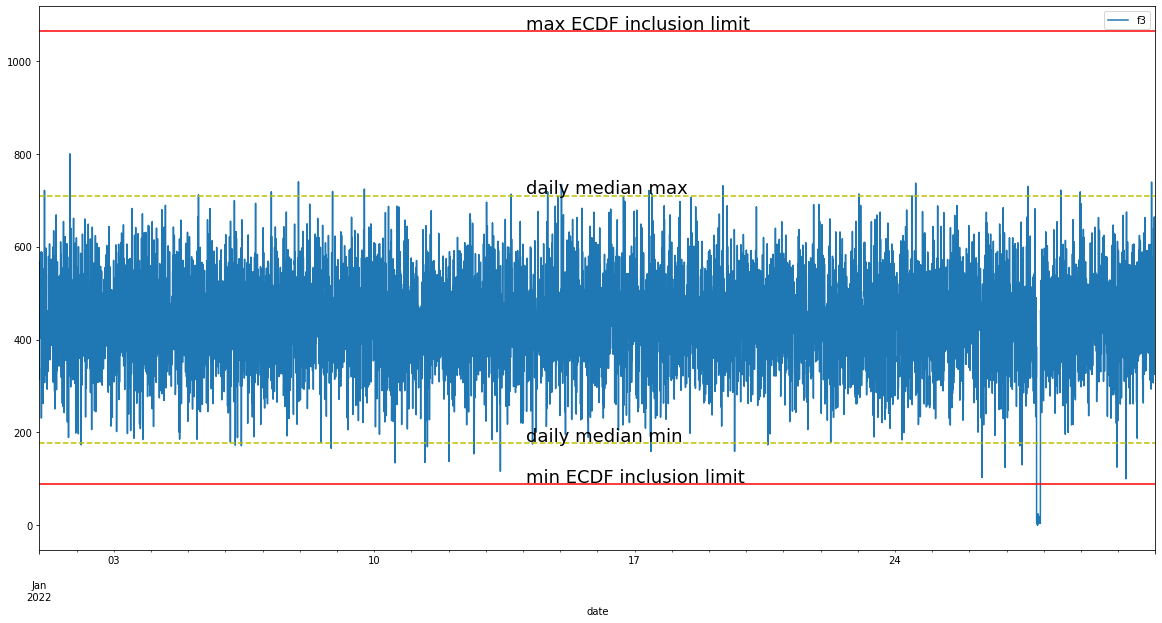

In [27]:
fig, ax = plt.subplots()
timeseriesDF.plot(y='f3', figsize=(20, 10), ax=ax)

plt.axhline(y=min_ecdf_inclusion, color='r', linestyle='-')
ax.text(timeseriesDF.index[(timeseriesDF.shape[0]//2)-550], min_ecdf_inclusion+5, 'min ECDF inclusion limit', size=18, fontdict=None)
plt.axhline(y=max_ecdf_inclusion, color='r', linestyle='-')
ax.text(timeseriesDF.index[(timeseriesDF.shape[0]//2)-550], max_ecdf_inclusion+5, 'max ECDF inclusion limit', size=18, fontdict=None)

plt.axhline(y=daily_norm['f3']['min'], color='y', linestyle='--')
ax.text(timeseriesDF.index[(timeseriesDF.shape[0]//2)-550], daily_norm['f3']['min']+5, 'daily median min', size=18, fontdict=None)
plt.axhline(y=daily_norm['f3']['max'], color='y', linestyle='--')
ax.text(timeseriesDF.index[(timeseriesDF.shape[0]//2)-550], daily_norm['f3']['max']+5, 'daily median max', size=18, fontdict=None)

print('min: ', min_ecdf_inclusion, '    max: ', max_ecdf_inclusion)

In [18]:
timeseriesDF.sample(100)

,f1,f2,f3,byDay,f1_norm_max,f2_norm_max,f3_norm_max,f3_norm_min
date,,,,,,,,
2022-01-29 15:10:00,2857.809086,285.894987,331.746477,1~29,0.268378,0.030624,0.467573,1.876769
2022-01-06 23:20:00,885.204679,26.533647,458.025148,1~6,0.083130,0.002842,0.645554,2.591158
2022-01-16 06:20:00,1687.122419,134.545829,438.513741,1~16,0.158439,0.014412,0.618054,2.480777
2022-01-23 02:40:00,2398.118414,2390.167516,452.601674,1~23,0.225209,0.256024,0.637910,2.560476
2022-01-09 15:15:00,662.470957,738.679887,511.047853,1~9,0.062213,0.079124,0.720285,2.891120
...,...,...,...,...,...,...,...,...
2022-01-03 05:35:00,2410.110003,8.669148,370.955810,1~3,0.226335,0.000929,0.522836,2.098586
2022-01-01 02:50:00,2088.731363,7282.519120,317.013469,1~1,0.196154,0.780069,0.446808,1.793421
2022-01-19 00:15:00,2333.211883,1383.361353,540.533335,1~19,0.219113,0.148179,0.761843,3.057927


<hr>

<h3>Add outlier fields for each signal<br></h3>
<b>Outliers are data rows that have feature column values outside of the ECDF inclusion limits</b><br>
0 = Normal, 1 = Outlier

In [130]:
timeseriesDF['f1_outlier'] = timeseriesDF['f1'] > daily_norm['f1']['max'] * 1.5
timeseriesDF['f2_outlier'] = timeseriesDF['f2'] > daily_norm['f2']['max'] * 1.5
timeseriesDF['f3_outlier'] = np.logical_or(timeseriesDF['f3'] > daily_norm['f3']['max'] * 1.5, timeseriesDF['f3'] < (daily_norm['f3']['min'] - daily_norm['f3']['min'] * 0.5))
timeseriesDF['multi_outlier'] = timeseriesDF[['f1_outlier','f2_outlier','f3_outlier']].sum(axis=1) >= 2
print('Percentage of rows that are outliers')
print(timeseriesDF[['f1_outlier','f2_outlier','f3_outlier','multi_outlier']].mean())

Percentage of rows that are outliers
f1_outlier       0.030093
f2_outlier       0.003704
f3_outlier       0.003472
multi_outlier    0.003472
dtype: float64


<b>Rows that have more than one True outlier field are multivariate outliers.</b>

In [126]:
timeseriesDF[timeseriesDF[['f1_outlier','f2_outlier','f3_outlier']].any(axis=1).values].sample(20)

,f1,f2,f3,byDay,f1_norm_max,f2_norm_max,f3_norm_max,f3_norm_min,f1_outlier,f2_outlier,f3_outlier,multi_outlier
date,,,,,,,,,,,,
2022-01-19 23:25:00,21218.000000,349.944503,493.332287,1~19,1.992593,0.037484,0.695316,2.790899,True,False,False,False
2022-01-19 19:15:00,20094.000000,1008.702806,570.709737,1~19,1.887038,0.108048,0.804374,3.228642,True,False,False,False
2022-01-28 14:25:00,24793.000000,4056.070317,450.308873,1~28,2.328323,0.434467,0.634678,2.547505,True,False,False,False
2022-01-28 10:35:00,24970.000000,2243.801248,378.734642,1~28,2.344945,0.240345,0.533799,2.142593,True,False,False,False
2022-01-19 16:00:00,20966.000000,5905.246409,442.513726,1~19,1.968928,0.632542,0.623691,2.503406,True,False,False,False
2022-01-19 15:20:00,20366.000000,787.806599,286.372990,1~19,1.912581,0.084386,0.403622,1.620081,True,False,False,False
2022-01-28 15:40:00,20275.000000,1468.646725,199.882221,1~28,1.904035,0.157315,0.281720,1.130782,True,False,False,False
2022-01-20 01:15:00,21004.000000,3386.405979,262.267875,1~20,1.972496,0.362736,0.369648,1.483712,True,False,False,False
2022-01-27 19:40:00,7323.176982,16423.000000,17.000000,1~27,0.687723,1.759155,0.023960,0.096173,False,True,True,True


<b>Highlight Outliers</b>

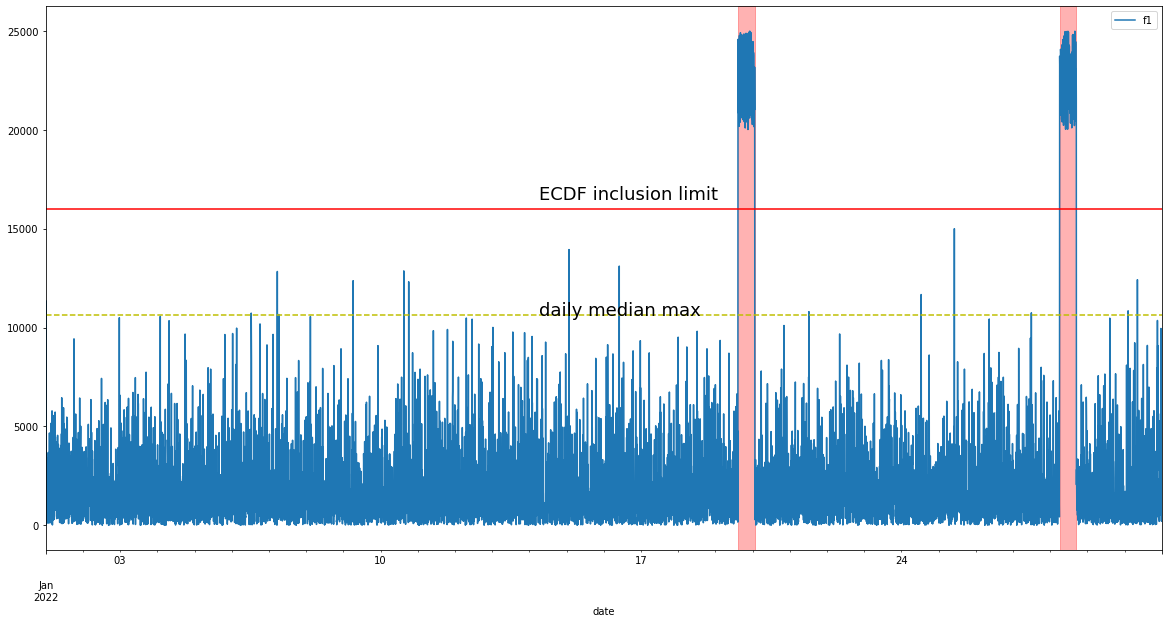

In [210]:
fig, ax = plt.subplots()
timeseriesDF.plot(y='f1', figsize=(20, 10), ax=ax)
# Values less than or equal to the horizontal line will be included in the daily normal max ECDF table to decide rarity
ECDF_inclusion_limit = daily_norm['f1']['max'] * 1.5
plt.axhline(y=ECDF_inclusion_limit, color='r', linestyle='-')
ax.text(timeseriesDF.index[(timeseriesDF.shape[0]//2)-500], ECDF_inclusion_limit+500, 'ECDF inclusion limit', size=18, fontdict=None)

plt.axhline(y=daily_norm['f1']['max'], color='y', linestyle='--')
ax.text(timeseriesDF.index[(timeseriesDF.shape[0]//2)-500], daily_norm['f1']['max'], 'daily median max', size=18, fontdict=None)

# Highlight Outliers
outlier_start = timeseriesDF[timeseriesDF['f1_outlier'] == True].index[0]
outlier_end = timeseriesDF[np.logical_and(timeseriesDF['f1_outlier'] == False, timeseriesDF.index > outlier_start)].index[0]
fig.get_axes()[0].axvspan(outlier_start, outlier_end, alpha=0.3, color='red')

outlier_start = timeseriesDF[np.logical_and(timeseriesDF['f1_outlier'] == True, timeseriesDF.index > outlier_end)].index[0]
outlier_end = timeseriesDF[np.logical_and(timeseriesDF['f1_outlier'] == False, timeseriesDF.index > outlier_start)].index[0]
fig.get_axes()[0].axvspan(outlier_start, outlier_end, alpha=0.3, color='red')

2022-01-02 16:10:00 - 2022-01-02 16:15:00


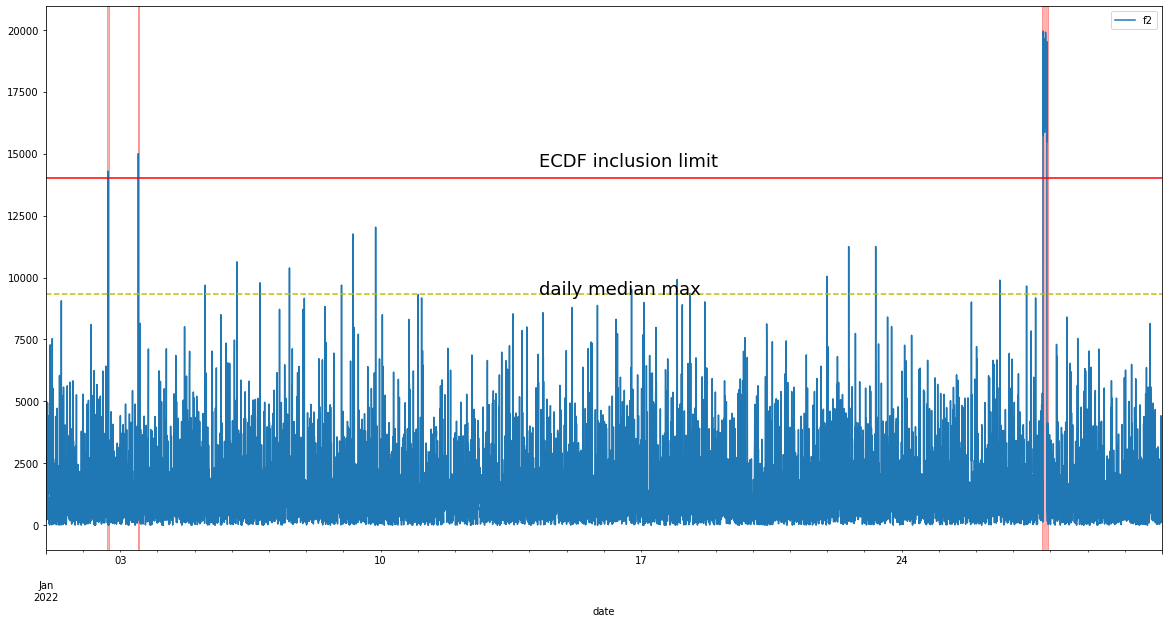

In [209]:
ECDF_inclusion_limit = daily_norm['f2']['max'] * 1.5
fig, ax = plt.subplots()
timeseriesDF.plot(y='f2', figsize=(20, 10), ax=ax)
plt.axhline(y=ECDF_inclusion_limit, color='r', linestyle='-')
ax.text(timeseriesDF.index[(timeseriesDF.shape[0]//2)-500], ECDF_inclusion_limit+500, 'ECDF inclusion limit', size=18, fontdict=None)

plt.axhline(y=daily_norm['f2']['max'], color='y', linestyle='--')
ax.text(timeseriesDF.index[(timeseriesDF.shape[0]//2)-500], daily_norm['f2']['max'], 'daily median max', size=18, fontdict=None)

# Highlight Outliers
outlier_start = timeseriesDF[timeseriesDF['f2_outlier'] == True].index[0]
outlier_end = timeseriesDF[np.logical_and(timeseriesDF['f2_outlier'] == False, timeseriesDF.index > outlier_start)].index[0]
fig.get_axes()[0].axvspan(outlier_start - pd.Timedelta(minutes=30), outlier_end + pd.Timedelta(minutes=30), alpha=0.3, color='red')
print(outlier_start, '-', outlier_end)

outlier_start = timeseriesDF[np.logical_and(timeseriesDF['f2_outlier'] == True, timeseriesDF.index > outlier_end)].index[0]
outlier_end = timeseriesDF[np.logical_and(timeseriesDF['f2_outlier'] == False, timeseriesDF.index > outlier_start)].index[0]
fig.get_axes()[0].axvspan(outlier_start - pd.Timedelta(minutes=30), outlier_end + pd.Timedelta(minutes=30), alpha=0.3, color='red')

outlier_start = timeseriesDF[np.logical_and(timeseriesDF['f2_outlier'] == True, timeseriesDF.index > outlier_end)].index[0]
outlier_end = timeseriesDF[np.logical_and(timeseriesDF['f2_outlier'] == False, timeseriesDF.index > outlier_start)].index[0]
fig.get_axes()[0].axvspan(outlier_start - pd.Timedelta(minutes=30), outlier_end + pd.Timedelta(minutes=30), alpha=0.3, color='red')

min:  88.38232802724815     max:  1064.2613505416484
2022-01-27 19:20:00 - 2022-01-27 21:50:00


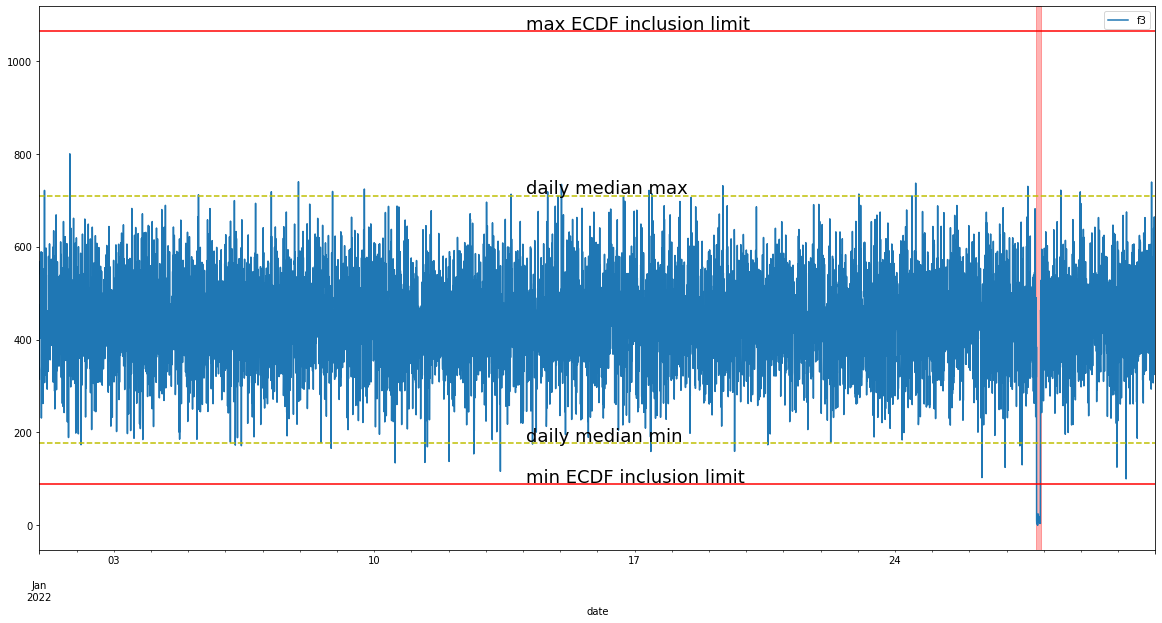

In [211]:
fig, ax = plt.subplots()
timeseriesDF.plot(y='f3', figsize=(20, 10), ax=ax)

plt.axhline(y=min_ecdf_inclusion, color='r', linestyle='-')
ax.text(timeseriesDF.index[(timeseriesDF.shape[0]//2)-550], min_ecdf_inclusion+5, 'min ECDF inclusion limit', size=18, fontdict=None)
plt.axhline(y=max_ecdf_inclusion, color='r', linestyle='-')
ax.text(timeseriesDF.index[(timeseriesDF.shape[0]//2)-550], max_ecdf_inclusion+5, 'max ECDF inclusion limit', size=18, fontdict=None)

plt.axhline(y=daily_norm['f3']['min'], color='y', linestyle='--')
ax.text(timeseriesDF.index[(timeseriesDF.shape[0]//2)-550], daily_norm['f3']['min']+5, 'daily median min', size=18, fontdict=None)
plt.axhline(y=daily_norm['f3']['max'], color='y', linestyle='--')
ax.text(timeseriesDF.index[(timeseriesDF.shape[0]//2)-550], daily_norm['f3']['max']+5, 'daily median max', size=18, fontdict=None)

print('min: ', min_ecdf_inclusion, '    max: ', max_ecdf_inclusion)

# Highlight Outliers
outlier_start = timeseriesDF[timeseriesDF['f3_outlier'] == True].index[0]
outlier_end = timeseriesDF[np.logical_and(timeseriesDF['f3_outlier'] == False, timeseriesDF.index > outlier_start)].index[0]
fig.get_axes()[0].axvspan(outlier_start - pd.Timedelta(minutes=30), outlier_end + pd.Timedelta(minutes=30), alpha=0.3, color='red')
print(outlier_start, '-', outlier_end)

<hr>

<h2>Add clustering of the binary outlier values so over time root cause predictions can be done.</h2>

<b>Setup KModes categorical clustering class</b>

In [19]:
%%capture
!pip install kmodes

In [20]:
from kmodes.kmodes import KModes

<b>Add a method to calculation an estimate of how many clusters exist in the binary data despite any noise in the values</b>

In [169]:
from collections import Counter
import scipy.stats as stats
import math

class BinaryDataset:
    def __init__(self, class_count_method='average_class_count', diff_percentile_threshold=99,
                 least_probable_threshold=1, verbose_level=0):
        
        self.class_count_method = class_count_method
        self.diff_percentile_threshold = diff_percentile_threshold
        self.least_probable_threshold = least_probable_threshold
        self.verbose_level = verbose_level
        
        self.classes_by_prevalence = None
        self.median_class_count = 0
        self.average_class_count = 0

    def get_classes_by_prevalence(self, data):
            """
            This method gets a count of each unique pattern of 1s and 0s across all rows,
            and then uses a few different methods to estimate the cut off in the sorted list of counts.

            A variable on the class called median_class_count is set that is the median of all the different estimates.

            Then the estimates for each method are returned.

            The different methods used are:

            largest_diff - Find the largest jump in count difference in the sorted count list.
            least_probable_diff - Compute a list of probabilities from the list of differences using a normal distribution and find the least probable difference from previous counts in the sorted list.
            diff_percentile - Take 1st matching index greater than the Xth percentile diff specified in diff_percentile_threshold
            least_probable_percentile - Take 1st matching index of the Xth percentile least diff probability.



            :param data: The original dataset used to get counts for each unique combination of column values
            :return: A dictionary containing a best guess of class count for each method implemented.
            """

            if self.verbose_level > 0:
                print('** Calculating classes by prevalence **')

            # Create a dictionary of variable pattern keys to their count values sorted largest count to smallest
            counter = Counter(map(tuple, data))
            counts = dict(counter)
            counts = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))

            # Transform the dictionary into a list of tuples to iterate over and lookup by indexes
            if self.verbose_level >= 2:
                print('\n===================================================== Class keys and counts')
            lstKeyValueMap = []
            for k, v in counts.items():
                lstKeyValueMap.append((k, v))
                if self.verbose_level >= 2:
                    print(k, v)

            # Reverse the list to be smallest to largest
            rev_lstKeyValueMap = list(reversed(lstKeyValueMap))

            # Iterate over the list of tuples (pattern key, count)
            # Start with the first two items to initialize a normal distribution
            # For each new item count value we will get a probability that it belongs to the normal distribution of all the items that came before
            counter = 2
            diff = max(rev_lstKeyValueMap[1][1] - rev_lstKeyValueMap[0][1], 0)

            # First two items have the same average diff
            threshold_diffs = [diff, diff]
            for i, item in enumerate(rev_lstKeyValueMap[1:-2]):
                next = rev_lstKeyValueMap[i + 2][1]

                d = item[1]
                diff = next - d

                threshold_diffs.append(diff)
                counter += 1
            if self.verbose_level >= 3:
                print('\n===================================================== Sorted diff counts between class keys')
                print(sorted(threshold_diffs))

            counter = 2
            summed = (threshold_diffs[0] + threshold_diffs[1])
            mean = summed / counter
            std = np.std([item for item in threshold_diffs[:counter]])
            std = max(std, 1)
            # First two items have 100% probability
            threshold_probs = [1, 1]
            stats_to_print = []
            for i, item in enumerate(threshold_diffs[2:]):
                d = item
                if mean == 0 and std == 0:
                    threshold_prob = 1
                else:
                    threshold_prob = stats.norm.pdf(d, loc=mean, scale=std)

                if self.verbose_level >= 4:
                    stats_to_print.append([d, round(threshold_prob, 8), round(mean, 4), round(std, 4)])

                threshold_probs.append(threshold_prob)
                counter += 1
                # Update the normal distribution parameters to include this new item for the next evaluation loop
                summed = sum([item for item in threshold_diffs[:counter]])
                mean = summed / counter
                std = np.std([item for item in threshold_diffs[:counter]])

            if self.verbose_level >= 4 and len(stats_to_print) > 0:
                pd.set_option('display.max_columns', len(stats_to_print[0]))
                pd.set_option('display.max_rows', 30)
                print('\n===================================================== least_probable_diff stats')
                df = pd.DataFrame(stats_to_print, columns=['diff', 'probability', 'mean', 'std']).set_index('diff')
                print(df.head(5))
                print(df.tail(15))

            results = {}

            # 1st matching index of largest diff
            threshold_idx = np.argmax(threshold_diffs)
            results['largest_diff'] = rev_lstKeyValueMap[threshold_idx:]

            # Get the index of the item least probable to belong to the normal distribution of all the items that came before
            # All items above this threshold are considered clusters/distribution peaks/classes
            # 1st matching index for least probable diff
            threshold_idx = np.argmin(threshold_probs)
            results['least_probable_diff'] = rev_lstKeyValueMap[threshold_idx:]

            # 1st matching index greater than the Xth percentile diff specified in diff_percentile_threshold
            threshold_idx = np.argmax(threshold_diffs > np.percentile(threshold_diffs, [self.diff_percentile_threshold]))
            results['diff_percentile'] = rev_lstKeyValueMap[threshold_idx:]

            # 1st matching index of the Xth percentile least diff probability
            threshold_idx = np.argmax(threshold_probs < np.percentile(threshold_probs, [self.least_probable_threshold]))
            results['least_probable_percentile'] = rev_lstKeyValueMap[threshold_idx:]

            self.median_class_count = math.ceil(np.median([len(classes) for classes in results.values()]))
            self.average_class_count = math.ceil(np.mean([len(classes) for classes in results.values()]))

            if self.verbose_level >= 4:
                print('\n===================================================== Classes by prevalence')
                for k, v in results.items():
                    print(k)
                    for class_key in v:
                        print(class_key)

            if self.verbose_level >= 2:
                print('\n===================================================== Class count method stats')
                print('max count diff between class keys:', max(threshold_diffs))
                print('diff_percentile:', self.diff_percentile_threshold, '%')
                print('least_probable_percentile:', self.least_probable_threshold, '%')
                print('median class count:', self.median_class_count)
                print('average class count:', self.average_class_count)
                for k, v in results.items():
                    print(k, 'class count:', len(v))


            return results

<b>Get counts of each unique combination of outlier fields</b>

In [140]:
unique_combinations = timeseriesDF[['f1_outlier','f2_outlier','f3_outlier']].groupby(['f1_outlier','f2_outlier','f3_outlier']).size().reset_index().rename(columns={0:'count'})

In [141]:
print('total:', len(timeseriesDF))
unique_combinations

total: 8640


,f1_outlier,f2_outlier,f3_outlier,count
0,False,False,False,8348
1,False,True,False,2
2,False,True,True,30
3,True,False,False,260


<b>Filter out all the non-outlier rows</b>

In [172]:
outliers_only = timeseriesDF[timeseriesDF[['f1_outlier','f2_outlier','f3_outlier']].sum(axis=1) > 0][['f1_outlier','f2_outlier','f3_outlier']].values

<b>Calculate a best guess for the number of unique clusters</b><br>
This example only has three binary columns and little noise in the values so doing this calculation is a bit of an overkill.

In [175]:
cluster_counter = BinaryDataset(class_count_method = 'average_class_count', verbose_level = 4)
cluster_counter.get_classes_by_prevalence(outliers_only)
cluster_count = cluster_counter.average_class_count

** Calculating classes by prevalence **

===================================================== Class keys and counts
(True, False, False) 260
(False, True, True) 30
(False, True, False) 2

===================================================== Sorted diff counts between class keys
[28, 28]

===================================================== Classes by prevalence
largest_diff
((False, True, False), 2)
((False, True, True), 30)
((True, False, False), 260)
least_probable_diff
((False, True, False), 2)
((False, True, True), 30)
((True, False, False), 260)
diff_percentile
((False, True, False), 2)
((False, True, True), 30)
((True, False, False), 260)
least_probable_percentile
((False, True, False), 2)
((False, True, True), 30)
((True, False, False), 260)

===================================================== Class count method stats
max count diff between class keys: 28
diff_percentile: 99 %
least_probable_percentile: 1 %
median class count: 3
average class count: 3
largest_diff class cou

<b>Use the KModes algorithm to learn the clusters of binary value combinations</b><br>
Once again this is overkill for this simple example.<br>
In a larger real world example with many more binary fields and noise in the values this trained model can be used to predict which "Type" of outlier event we are seeing.<br>
Over time you can build up a catalog of event types that point to root causes for faster diagnosis of outlier events.

In [181]:
kmode = KModes(n_clusters = cluster_count, init = "Cao", verbose = 2)
clusters = kmode.fit_predict(outliers_only)

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...


In [184]:
np.unique(clusters)

array([0, 1, 2], dtype=uint16)

In [178]:
print(kmode.cluster_centroids_)

[[ True False False]
 [False  True False]
 [False  True  True]]
